# Read dataset

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ml_functions import *

df = pd.read_csv('toy_dataset.csv', index_col=0)

df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

display(df.head())
print(df.shape)

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,r15,r16,InputA,InputI,OutputX,OutputN,id,growth,status,strain
0,0.00,0.10,-0.10,-0.20,1.20,1.00,1.00,1.00,1.00,-0.00,...,0.00,1.00,1.00,1.00,3.00,1.00,r1,3.00,infeasible,1
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r3,9.00,optimal,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r2,9.00,optimal,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r4,9.00,optimal,1
4,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r5,9.00,infeasible,1


(4046, 25)


Intial dataset size.

In [2]:
df[['rxn_a','rxn_b','rxn_c']] = df['id'].str.split(',', expand=True)

#### Create `no_deletions` column keeping the number of deletions performed

In [3]:
def count_deletions(x):

    return len(x.split(','))

no_delitions = []
for row in range(len(df)):

    num = count_deletions(df['id'].iloc[row])
    no_delitions.append(num)

df['no_deletions'] = no_delitions
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
0,0.00,0.10,-0.10,-0.20,1.20,1.00,1.00,1.00,1.00,-0.00,...,3.00,1.00,r1,3.00,infeasible,1,r1,None,None,1
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r3,9.00,optimal,1,r3,None,None,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r2,9.00,optimal,1,r2,None,None,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r4,9.00,optimal,1,r4,None,None,1
4,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r5,9.00,infeasible,1,r5,None,None,1


### Store reactions names

In [4]:
# Store all reactions names
gem_rxn = df[df['no_deletions'] == 1]['id'].unique()

# Some statistical study

In [5]:
df['status'].value_counts()

infeasible    2802
optimal       1244
Name: status, dtype: int64

In [6]:
# Subset of df containing only infeasible rows
df_inf = df[df['status'] == 'infeasible']

Οι παρακάτω αντιδράσεις εάν κοπούν οδηγούν σε **infeasible** κατάσταση. Επομένως, ΔΕ θα πρέπει να περιλαμβάνονται στα deletions. Οι αντιδράσεις αυτές, δηλαδή, θα πρέπει να **προστατευτούν** από τα reaction deletions.

In [7]:
critical_rxn = df_inf[df_inf['no_deletions']==1]['id'].unique()
critical_rxn

array(['r1', 'r5', 'r6', 'r7', 'r8', 'r9', 'r11', 'r12', 'r13', 'outputK',
       'r16', 'OutputX'], dtype=object)

Οι αντιδράσεις που φαίνονται στο επόμενο κελί __ΔΕΝ__ οδήγησαν __ποτέ__ σε _infeasible_ status όταν κόπηκαν.

Μια λογική είναι να κοπούν οι παρακάτω αντιδράσεις. Εξαίρεση, οι αντιδράσεις που αφορούν input/output.

In [8]:
rxn_deletable = list(set(df_inf[df_inf['no_deletions']==1]['id'].unique()) ^ set(gem_rxn))
rxn_deletable

['r10', 'r3', 'InputA', 'r14', 'r2', 'OutputN', 'r4', 'InputI', 'r15']

In [9]:
index_del_rxn_a = df.loc[df['rxn_a'].isin(critical_rxn)].index
df.drop(index_del_rxn_a, inplace=True)

index_del_rxn_b = df.loc[df['rxn_b'].isin(critical_rxn)].index
df.drop(index_del_rxn_b, inplace=True)

index_del_rxn_c = df.loc[df['rxn_c'].isin(critical_rxn)].index
df.drop(index_del_rxn_c, inplace=True)

In [10]:
df.shape

(438, 29)

### Find and Delete Duplicated Rows 

In [11]:
index_a = df[df['rxn_a'] == df['rxn_b']].index
df.drop(index_a, axis=0, inplace=True)

index_b = df[df['rxn_a'] == df['rxn_c']].index
df.drop(index_b, axis=0, inplace=True)

index_c = df[df['rxn_b'] == df['rxn_c']].index
df.drop(index_c, axis=0, inplace=True)

df.shape

(258, 29)

In [12]:
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r3,9.00,optimal,1,r3,None,None,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r2,9.00,optimal,1,r2,None,None,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r4,9.00,optimal,1,r4,None,None,1
9,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r10,9.00,optimal,1,r10,None,None,1
14,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r14,9.00,optimal,1,r14,None,None,1


### Deletions matrix

"Binary" matrix:
    
    -cols: reactions
    
    -values: 1 (reaction is deleted) - 0 (otherwise)

In [13]:
# deletions = pd.DataFrame()

# for rxn in rxn_deletable:
#     deletions[rxn] = np.nan
    
# deletions['id'] = df['id']
# deletions.tail()

# for row in range(deletions.shape[0]):

#     deleted_rxn = deletions.iloc[row]['id']
    
#     for col in deletions.columns:
#         if(col in deleted_rxn): deletions[col].iloc[row] = 1

# deletions.fillna(0, inplace=True)

# new_names = []
# for col in deletions.columns:
#     new_names.append('del_'+col)
    
# deletions.columns = new_names
# deletions.drop('del_id', axis=1, inplace=True)

# df = pd.concat([df, deletions], axis=1)
# df.head()

In [14]:
# pd.set_option('display.max_columns', None)
# df.tail()

In [15]:
df.shape

(258, 29)

In [16]:
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r3,9.00,optimal,1,r3,None,None,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r2,9.00,optimal,1,r2,None,None,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r4,9.00,optimal,1,r4,None,None,1
9,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r10,9.00,optimal,1,r10,None,None,1
14,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r14,9.00,optimal,1,r14,None,None,1


# Further Study dataset

In [17]:
pd.DataFrame(df[['growth']].describe()).T

,count,mean,std,min,25%,50%,75%,max
growth,258.00,4.94,3.37,-3.00,3.00,6.00,6.00,10.00


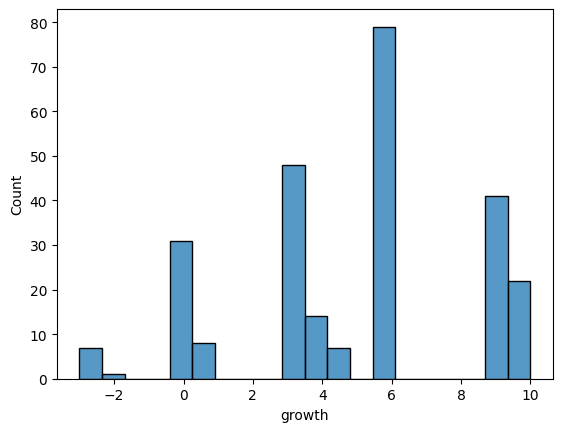

In [18]:
sns.histplot(data=df, x="growth", bins=20)
plt.show()

## Negative growth

In [19]:
df[df['growth'] < 0]

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
243,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"InputA,InputI",-3.00,infeasible,1,InputA,InputI,None,2
684,0.00,0.00,-1.00,-2.00,1.00,-1.00,-1.00,-1.00,-0.00,1.00,...,-3.00,1.00,"r3,InputA,InputI",-3.00,infeasible,1,r3,InputA,InputI,3
874,0.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"r2,InputA,InputI",-3.00,infeasible,1,r2,InputA,InputI,3
1045,0.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"r4,InputA,InputI",-3.00,infeasible,1,r4,InputA,InputI,3
1728,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"r10,InputA,InputI",-3.00,infeasible,1,r10,InputA,InputI,3
1958,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,-0.00,1.00,...,-3.00,1.00,"r14,InputA,InputI",-3.00,infeasible,1,r14,InputA,InputI,3
1979,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,-0.00,1.00,...,-3.00,1.00,"r15,InputA,InputI",-3.00,infeasible,1,r15,InputA,InputI,3
2009,0.00,0.10,-0.43,-0.87,0.20,-0.67,-0.67,-1.00,-0.00,0.33,...,-2.00,0.00,"InputA,InputI,OutputN",-2.00,infeasible,1,InputA,InputI,OutputN,3
2544,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-1.00,0.00,1.00,...,-0.00,0.00,"r3,r2,OutputN",-0.00,optimal,2,r3,r2,OutputN,3
2562,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-1.00,0.00,1.00,...,-0.00,0.00,"r3,r4,OutputN",-0.00,optimal,2,r3,r4,OutputN,3


11 rows of __negative__ growth

Replace negative growth with 0

In [20]:
for row in range(len(df)):
    if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0

/tmp/ipykernel_9869/766195947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0


## Create _dummy variables_ for `status`

In [21]:
dummy_status = pd.get_dummies(df['status'])
df = pd.concat([df, dummy_status], axis=1)
df

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions,infeasible,optimal
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,r3,9.00,optimal,1,r3,None,None,1,0,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,r2,9.00,optimal,1,r2,None,None,1,0,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,r4,9.00,optimal,1,r4,None,None,1,0,1
9,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,r10,9.00,optimal,1,r10,None,None,1,0,1
14,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,r14,9.00,optimal,1,r14,None,None,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3986,1.00,1.00,-0.00,-0.00,2.00,2.00,2.00,2.00,0.00,0.00,...,"r14,InputI,OutputN",6.00,optimal,2,r14,InputI,OutputN,3,0,1
4002,0.00,0.10,-0.10,-0.20,0.20,0.00,0.00,0.00,0.00,-0.00,...,"r15,InputA,InputI",0.00,optimal,2,r15,InputA,InputI,3,0,1
4004,0.00,0.10,-0.10,-0.20,0.20,0.00,0.00,0.00,0.00,-0.00,...,"r15,InputA,OutputN",0.00,optimal,2,r15,InputA,OutputN,3,0,1
4007,1.00,1.00,-0.00,0.00,2.00,2.00,2.00,2.00,0.00,0.00,...,"r15,InputI,OutputN",6.00,optimal,2,r15,InputI,OutputN,3,0,1


### Check Linear Correlations

##### Point Biserial Correlation

In [22]:
pearsons = df.drop(columns=critical_rxn).corr(numeric_only=True)['optimal'].sort_values(ascending=False)
spearman = df.drop(columns=critical_rxn).corr(numeric_only=True, method='spearman')['optimal'].sort_values(ascending=False)

corr_matrix = pd.DataFrame({'pearsons':pearsons, 'spearman':spearman})
corr_matrix.sort_values(by='pearsons')

,pearsons,spearman
infeasible,-1.00,-1.00
no_deletions,-0.25,-0.24
InputI,-0.22,-0.22
r14,-0.21,-0.30
r15,-0.21,-0.16
OutputN,-0.13,-0.11
r2,-0.07,-0.13
r4,-0.07,-0.10
r10,0.01,0.13
growth,0.05,0.05


In [23]:
corr_matrix[abs(corr_matrix['pearsons']) < 0.1]

,pearsons,spearman
growth,0.05,0.05
r10,0.01,0.13
r2,-0.07,-0.13
r4,-0.07,-0.10


# AI / ML Ideas

## Create _training_ and _test_ sets and _data normalization_

Create a `df` keeping only _non critical_ reactions.

In [24]:
df.drop(columns=critical_rxn, inplace=True)

In [25]:
df.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN',
       'id', 'growth', 'status', 'strain', 'rxn_a', 'rxn_b', 'rxn_c',
       'no_deletions', 'infeasible', 'optimal'],
      dtype='object')

In [26]:
cols_to_drop = ['id', 'rxn_a', 'rxn_b', 'rxn_c', 'status']
df.drop(columns=cols_to_drop, inplace=True)

df.head()

,r3,r2,r4,r10,r14,r15,InputA,InputI,OutputN,growth,strain,no_deletions,infeasible,optimal
1,0.00,1.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
2,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
3,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
9,0.10,0.90,1.80,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
14,0.10,0.90,1.80,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1


In [27]:
df.shape

(258, 14)

In [28]:
df['val_growth'] = np.nan

growth_strain_1 = 9
growth_strain_2 = 6
growth_threshold = 0.1

for row in range(len(df)):
    
    if(df['strain'].iloc[row] == 1):
        if (df['growth'].iloc[row] >  growth_strain_1 - growth_strain_1 * growth_threshold) and (df['growth'].iloc[row] >  growth_strain_1 - growth_strain_1 * growth_threshold):
            df['val_growth'].iloc[row] = 1
        else:
            df['val_growth'].iloc[row] = 0
    elif(df['strain'].iloc[row] == 2):
        if (df['growth'].iloc[row] >  growth_strain_2 - growth_strain_2 * growth_threshold) and (df['growth'].iloc[row] >  growth_strain_2 - growth_strain_2 * growth_threshold):
            df['val_growth'].iloc[row] = 1
        else:
            df['val_growth'].iloc[row] = 0

/tmp/ipykernel_9869/253647673.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_growth'].iloc[row] = 1
/tmp/ipykernel_9869/253647673.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_growth'].iloc[row] = 0
/tmp/ipykernel_9869/253647673.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_growth'].iloc[row] = 1
/tmp/ipykernel_9869/253647673.py:18: SettingWithCopyWarning: 
A value is trying to be set on a co

### Basic ML libraries

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Define **target** variable

We need to better define the target that we want to predict!

(The most simple and obvious answer is to predit **optimal** column)

Θα *δοκιμάσω* να χρησιμοποιήσω ως στόχο την πρόβλεψη του αν πρόκειται για infeasible

In [30]:
df['target'] = (1-df['val_growth']) * df['infeasible']
# df['target'] = df['infeasible']
df['target'].value_counts()

0.00    207
1.00     51
Name: target, dtype: int64

In [31]:
df.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN',
       'growth', 'strain', 'no_deletions', 'infeasible', 'optimal',
       'val_growth', 'target'],
      dtype='object')

In [32]:
X = df.drop(['optimal', 'infeasible', 'growth', 'strain', 'no_deletions', 'target', 'val_growth'], axis=1)
y = df['target']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y, random_state=42)

(258, 9)
(258,)


In [33]:
X_train.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN'], dtype='object')

Use of stratify sampling to get the same optimal/infeasible rates on train and test sets as to the original dataset.

In [34]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled = X_train
X_test_scaled = X_test

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression().fit(X_train_scaled, y_train)

validation_classification(lr_model, X_test_scaled, y_test)

ROC-AUC = 0.6523809523809524
ACCURACY = 0.8076923076923077
F1 = 0.4444444444444445


### SVM Classifier

In [37]:
svc_model, svc_scores = train_svm(X_train_scaled, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 2/3; 2/36] START C=0.001, gamma=1, kernel=linear............................
[CV 2/3; 2/36] END C=0.001, gamma=1, kernel=linear;, score=0.892 total time=   0.0s
[CV 3/3; 3/36] START C=0.001, gamma=2, kernel=rbf...............................
[CV 3/3; 3/36] END C=0.001, gamma=2, kernel=rbf;, score=0.854 total time=   0.0s
[CV 1/3; 4/36] START C=0.001, gamma=2, kernel=linear............................
[CV 1/3; 4/36] END C=0.001, gamma=2, kernel=linear;, score=0.677 total time=   0.0s
[CV 3/3; 4/36] START C=0.001, gamma=2, kernel=linear............................
[CV 3/3; 4/36] END C=0.001, gamma=2, kernel=linear;, score=0.903 total time=   0.0s
[CV 2/3; 5/36] START C=0.001, gamma=3, kernel=rbf...............................
[CV 2/3; 5/36] END C=0.001, gamma=3, kernel=rbf;, score=0.841 total time=   0.0s
[CV 2/3; 6/36] START C=0.001, gamma=3, kernel=linear.....

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [38]:
validation_classification(svc_model, X_test_scaled, y_test)

ROC-AUC = 0.5
ACCURACY = 0.8076923076923077
F1 = 0.0


### XGBoost Classifier

In [39]:
xgb_model, xgb_scores = xgb_classifier(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 2/3; 3/36] START C=0.001, gamma=2, kernel=rbf...............................
[CV 2/3; 3/36] END C=0.001, gamma=2, kernel=rbf;, score=0.841 total time=   0.0s
[CV 3/3; 9/36] START C=0.005, gamma=2, kernel=rbf...............................
[CV 3/3; 9/36] END C=0.005, gamma=2, kernel=rbf;, score=0.761 total time=   0.0s
[CV 2/3; 11/36] START C=0.005, gamma=3, kernel=rbf..............................
[CV 2/3; 11/36] END C=0.005, gamma=3, kernel=rbf;, score=0.844 total time=   0.0s
[CV 1/3; 13/36] START C=0.01, gamma=1, kernel=rbf...............................
[CV 1/3; 13/36] END C=0.01, gamma=1, kernel=rbf;, score=0.860 total time=   0.0s
[CV 1/3; 15/36] START C=0.01, gamma=2, kernel=rbf...............................
[CV 1/3; 15/36] END C=0.01, gamma=2, kernel=rbf;, score=0.863 total time=   0.0s
[CV 1/3; 23/36] START C=0.02, gamma=3, kernel=rbf...............................
[CV 1/3; 23/36] END C=0.02, gamma=3, kernel=rb

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 34/36] START C=0.1, gamma=2, kernel=linear.............................
[CV 1/3; 34/36] END C=0.1, gamma=2, kernel=linear;, score=0.673 total time=   0.0s
[CV 2/3; 36/36] START C=0.1, gamma=3, kernel=linear.............................
[CV 2/3; 36/36] END C=0.1, gamma=3, kernel=linear;, score=0.853 total time=   0.0s
[CV 1/3; 3/36] START C=0.001, gamma=2, kernel=rbf...............................
[CV 1/3; 3/36] END C=0.001, gamma=2, kernel=rbf;, score=0.645 total time=   0.0s
[CV 3/3; 5/36] START C=0.001, gamma=3, kernel=rbf...............................
[CV 3/3; 5/36] END C=0.001, gamma=3, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3; 11/36] START C=0.005, gamma=3, kernel=rbf..............................
[CV 1/3; 11/36] END C=0.005, gamma=3, kernel=rbf;, score=0.599 total time=   0.0s
[CV 2/3; 11/36] START C=0.005, gamma=3, kernel=rbf..............................
[CV 2/3; 11/36] END C=0.005, gamma=3, kern

[CV 3/3; 11/36] START C=0.005, gamma=3, kernel=rbf..............................
[CV 3/3; 11/36] END C=0.005, gamma=3, kernel=rbf;, score=0.969 total time=   0.0s
[CV 1/3; 12/36] START C=0.005, gamma=3, kernel=linear...........................
[CV 1/3; 12/36] END C=0.005, gamma=3, kernel=linear;, score=0.834 total time=   0.0s
[CV 2/3; 16/36] START C=0.01, gamma=2, kernel=linear............................
[CV 2/3; 16/36] END C=0.01, gamma=2, kernel=linear;, score=0.577 total time=   0.0s
[CV 3/3; 16/36] START C=0.01, gamma=2, kernel=linear............................
[CV 3/3; 16/36] END C=0.01, gamma=2, kernel=linear;, score=0.663 total time=   0.0s
[CV 2/3; 26/36] START C=0.05, gamma=1, kernel=linear............................
[CV 2/3; 26/36] END C=0.05, gamma=1, kernel=linear;, score=0.561 total time=   0.0s
[CV 3/3; 26/36] START C=0.05, gamma=1, kernel=linear............................
[CV 3/3; 26/36] END C=0.05, gamma=1, kernel=linear;, score=0.719 total time=   0.0s
[CV 1/3; 27

[CV 2/3; 6/50] START colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=12, min_child_weight=7
[CV 2/3; 6/50] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=12, min_child_weight=7;, score=0.936 total time=   0.1s
[CV 3/3; 6/50] START colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=12, min_child_weight=7
[CV 3/3; 6/50] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=12, min_child_weight=7;, score=0.932 total time=   0.0s
[CV 3/3; 11/50] START colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5
[CV 3/3; 11/50] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5;, score=0.964 total time=   0.1s
[CV 1/3; 12/50] START colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3
[CV 1/3; 12/50] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3;, score=0.953 total time=   0.1s
[CV 1/3; 17/50] ST

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3; 13/50] START colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=8, min_child_weight=3
[CV 3/3; 13/50] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=8, min_child_weight=3;, score=0.941 total time=   0.0s
[CV 1/3; 14/50] START colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=1
[CV 1/3; 14/50] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=1;, score=0.945 total time=   0.1s
[CV 1/3; 17/50] START colsample_bytree=0.4, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3
[CV 1/3; 17/50] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3;, score=0.932 total time=   0.1s
[CV 2/3; 17/50] START colsample_bytree=0.4, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3
[CV 2/3; 17/50] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight

[CV 1/3; 35/50] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5;, score=0.890 total time=   0.1s
[CV 2/3; 35/50] START colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5
[CV 2/3; 35/50] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5;, score=0.893 total time=   0.0s
[CV 2/3; 42/50] START colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3
[CV 2/3; 42/50] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3;, score=0.917 total time=   0.1s
[CV 3/3; 42/50] START colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3
[CV 3/3; 42/50] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3;, score=0.957 total time=   0.1s
[CV 1/3; 43/50] START colsample_bytree=0.4, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1
[CV 1/3; 43/50] END colsamp

[CV 1/3; 1/50] START colsample_bytree=0.5, gamma=0.4, learning_rate=0.05, max_depth=5, min_child_weight=7
[CV 1/3; 1/50] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.05, max_depth=5, min_child_weight=7;, score=0.610 total time=   0.1s
[CV 3/3; 3/50] START colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=8, min_child_weight=1
[CV 3/3; 3/50] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=8, min_child_weight=1;, score=0.970 total time=   0.1s
[CV 3/3; 7/50] START colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=3, min_child_weight=1
[CV 3/3; 7/50] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=3, min_child_weight=1;, score=0.975 total time=   0.0s
[CV 1/3; 8/50] START colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3
[CV 1/3; 8/50] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3;, score=0.959 total time=   0.1s
[CV 1/3; 13/50] START colsampl

In [40]:
validation_classification(xgb_model, X_test_scaled, y_test)

ROC-AUC = 0.888095238095238
ACCURACY = 0.9423076923076923
F1 = 0.8421052631578948


# Feature Importance to detect reactions for knock-out

In [41]:
import shap

explainer = shap.TreeExplainer(xgb_model, X_test_scaled, feature_names=X_test.columns)
shap_values = explainer(X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


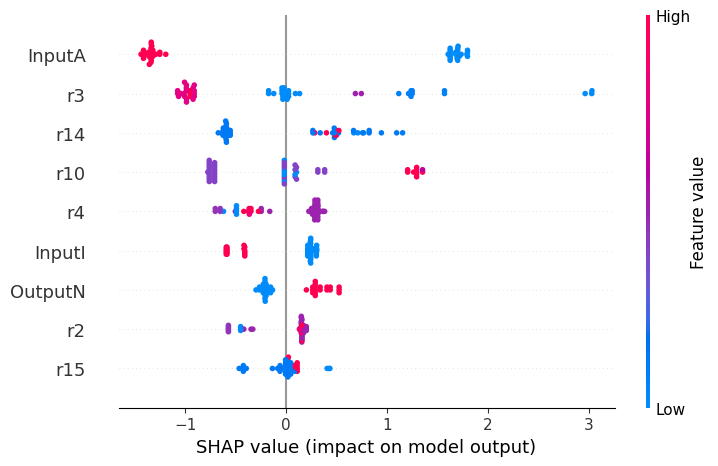

In [42]:
shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])

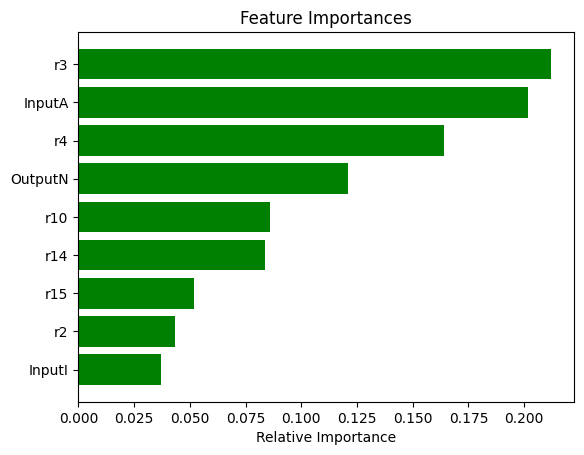

In [43]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Artificial Neural Networks

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2022-11-15 12:55:48.935623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 12:55:49.088449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 12:55:49.088472: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 12:55:49.113952: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 12:55:49.654530: W tensorflow/stream_executor/platform/de

In [45]:
n_inputs = len(X_train.columns)

In [46]:
model = Sequential()
model.add(Dense(8, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=5)

Epoch 1/25


2022-11-15 12:55:50.243504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 12:55:50.243520: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 12:55:50.243534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (comex-dell): /proc/driver/nvidia/version does not exist
2022-11-15 12:55:50.243695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


42/42 [==============================] - 0s 861us/step - loss: 0.6267 - accuracy: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/25
42/42 [==============================] - 0s 1ms/step - loss: 0.5768 - accuracy: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/25
42/42 [==============================] - 0s 1ms/step - loss: 0.5272 - accuracy: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/25
42/42 [==============================] - 0s 1ms/step - loss: 0.4794 - accuracy: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/25
42/42 [==============================] - 0s 1ms/step - loss: 0.4419 - accuracy: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/25
42/42 [==============================] - 0s 2ms/step - loss: 0.4167 - accuracy: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/25
42/42 [==============================] - 0s 1ms/step - loss: 0.3983 - accuracy: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/

In [47]:
score = model.evaluate(X_test_scaled, y_test,verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.8077 - precision: 0.5000 - recall: 0.3000


In [48]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)

print('ROC-AUC =', roc_auc_score(y_test, y_pred))
print('ACCURACY =', accuracy_score(y_test, y_pred))
print('F1 =', f1_score(y_test, y_pred))

2/2 [==============================] - 0s 2ms/step
ROC-AUC = 0.6142857142857143
ACCURACY = 0.8076923076923077
F1 = 0.37499999999999994


In [49]:
e = shap.KernelExplainer(model, X_train_scaled)
shap_values = e.shap_values(X_test_scaled)

Using 206 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/52 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


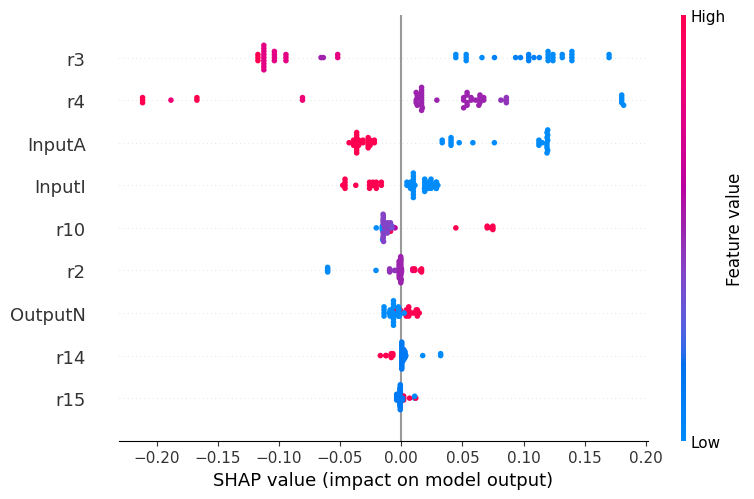

In [50]:
shap.summary_plot(shap_values[0], X_test_scaled, feature_names=X_test.columns)

# ELI5 

In [51]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from sklearn.svm import SVC

perm = PermutationImportance(xgb_model).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0577 ± 0.0421,r3
0.0423 ± 0.0510,InputA
0.0385 ± 0.0000,r15
0.0154 ± 0.0288,r10
0.0154 ± 0.0154,OutputN
0.0038 ± 0.0449,r4
0.0038 ± 0.0288,r2
0 ± 0.0000,InputI
-0.0077 ± 0.0188,r14


# Feature Selection

## RFECV

In [52]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

estimator = xgb_model

selector = RFECV(estimator)
selector = selector.fit(X_train_scaled, y_train)

selected_features = pd.DataFrame()
selected_features['selected'] = selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = selector.ranking_
selected_features[selected_features['selected'] == True]

,selected,features_names,rank
0,True,r3,1
3,True,r10,1
4,True,r14,1
6,True,InputA,1


In [53]:
selected_features[selected_features['selected'] == False].sort_values(by='rank')

,selected,features_names,rank
8,False,OutputN,2
2,False,r4,3
1,False,r2,4
5,False,r15,5
7,False,InputI,6


## Boruta

In [54]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=12, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [55]:
from boruta import BorutaPy

# model = xgb.XGBClassifier()
model = xgb_model

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=0,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

feat_selector.fit(np.array(X_train_scaled), np.array(y_train))

BorutaPy(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 callbacks=None, colsample_bylevel=1,
                                 colsample_bynode=1, colsample_bytree=0.3,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=0.2, gpu_id=-1,
                                 grow_policy='depthwise', importance_type=None,
                                 interaction_constraints='', learning_rate=0.25,
                                 max_bin=256, max_cat_threshold=64,
                                 max_cat_to_onehot=4, max_delta_step=0,
                                 max_depth=12, max_leaves=0, min_child_weight=3,
                                 missing=nan, monotone_constraints='()',
                                 n_estimators=35, n_jobs=0, num_parallel_tree=1,
                                 predictor='auto', random_state=304561939, ...),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FDED00FB440)

In [56]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train.columns[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:  r3  - Ranking:  2
Doesn't pass the test:  r2  - Ranking:  2
Doesn't pass the test:  r4  - Ranking:  2
Doesn't pass the test:  r10  - Ranking:  2
Doesn't pass the test:  r14  - Ranking:  2
Doesn't pass the test:  r15  - Ranking:  2
Passes the test:  InputA  - Ranking:  1
Doesn't pass the test:  InputI  - Ranking:  4
Doesn't pass the test:  OutputN  - Ranking:  3


In [57]:
selected_features = pd.DataFrame()
selected_features['selected'] = feat_selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = feat_selector.ranking_
selected_features.sort_values(by='selected')

,selected,features_names,rank
0,False,r3,2
1,False,r2,2
2,False,r4,2
3,False,r10,2
4,False,r14,2
5,False,r15,2
7,False,InputI,4
8,False,OutputN,3
6,True,InputA,1


# Validate Deletions

In [58]:
from cobra.io import load_model
from cobra.io.json import load_json_model

from main import *

# cobra_model = load_model("textbook")

# Load toy models created by Stefanos
cobra_model_1 = load_json_model('toy_1.json')
cobra_model_2 = load_json_model('toy_2.json')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [59]:
ann = ['r10', 'r4', 'r14', 'r15']

with cobra_model_1:
    for rxn in ann:
        cobra_model_1.reactions.get_by_id(rxn).knock_out()
    solution =  cobra_model_1.optimize()    
    print(solution.objective_value)
    print(solution.status)

with cobra_model_2:
    for rxn in ann:
        cobra_model_2.reactions.get_by_id(rxn).knock_out()
    solution =  cobra_model_2.optimize()    
    print(solution.objective_value)
    print(solution.status)

9.0
optimal
6.000000000000001
optimal
